<a href="https://colab.research.google.com/github/TheAmirHK/Financial_time_series/blob/main/Stock%20price%20prediction%20and%20simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime
from datetime import datetime, date, timedelta
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , mean_absolute_percentage_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Dense

from scipy.stats import norm, gmean, cauchy
# For warnings suppression
import warnings
warnings.filterwarnings("ignore")

In [2]:
# The stocks to be analyzed !
stock = ["AAPL"]

# define the number of year to be studied
NYears = 5

# Define the time period of study
end = datetime.today()
start = end - timedelta(days = NYears*365)
# Download stock data
data = pdr.get_data_yahoo(stock, start, end)

[*********************100%%**********************]  1 of 1 completed


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1131
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2580.383
Date:                Thu, 23 Nov 2023   AIC                           5166.766
Time:                        15:37:35   BIC                           5181.856
Sample:                             0   HQIC                          5172.467
                               - 1131                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0571      0.023     -2.503      0.012      -0.102      -0.012
ar.L2         -0.0325      0.023     -1.395      0.163      -0.078       0.013
sigma2         5.6360      0.159     35.395      0.0

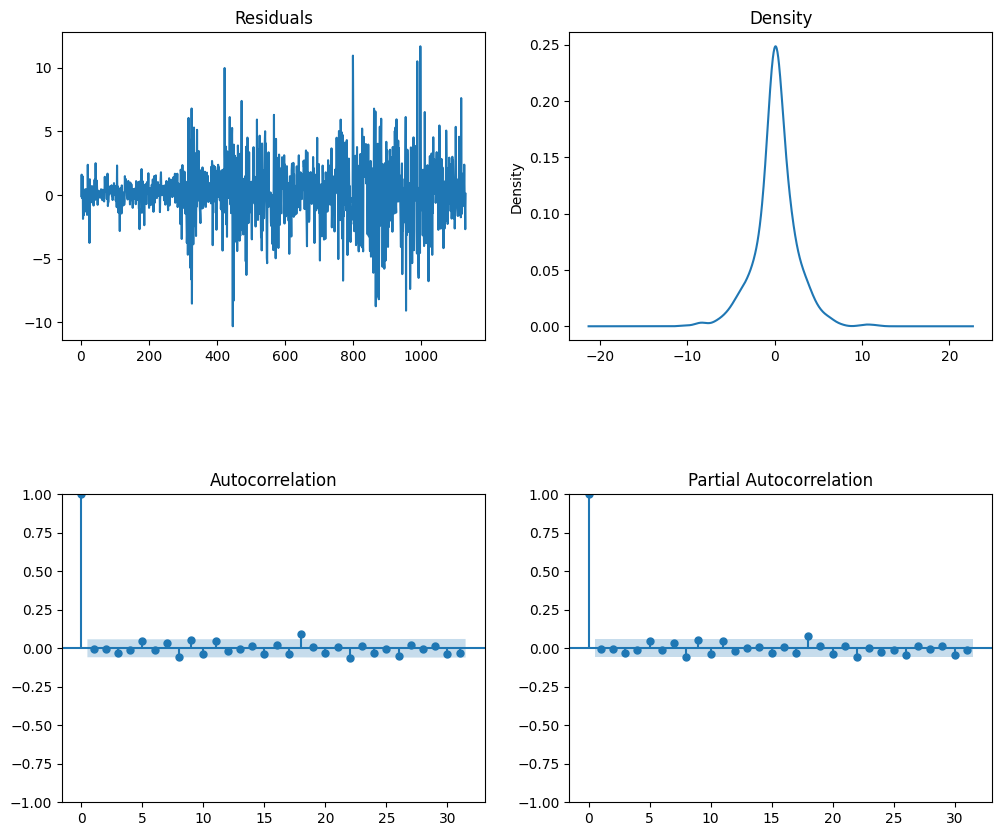

count    1130.000000
mean        0.124907
std         2.371781
min       -10.311137
25%        -0.867971
50%         0.130561
75%         1.239138
max        11.689347
dtype: float64


In [3]:
""" Using AutoRegressive Integrated Moving Average (ARIMA) method to forecast the future price of a stock:
ARIMA method predicts future price of a atock examining the differences between values in the series instead of through actual values.

ARIMA method includes parameters such as p, d, and q, where:
p: the number of lag observations in the model.
d: degree of differencing.
q: order of the moving average.

"""
# Autocorrelation test and transforming non-stationary time-series to stationary using differencing for ARIMA
def diff_data(data, plot=None):
    adf_test = adfuller(data)
    #print(f'p-value: {adf_test[1]}')
    count_diff = 0
    while adf_test[1]>0.05 : # continue differences till p-value is less than 5 percents
      df_train_diff = data.diff().dropna()
      count_diff += 1
      adf_test = adfuller(df_train_diff)
    if plot is not None:
        df_train_diff.plot()
        acf_diff = plot_acf(df_train_diff)
        pacf_diff = plot_pacf(df_train_diff)
    return count_diff


# Define train and valid data
def split_data (data , test_size= None, split_date=None):

    input = pd.DataFrame(data)
    input["date"]= input.index
    input = input.set_index('date')
    input = input.reset_index(drop=True)

    if ((split_date is not None) and (test_size is None)):
      split_date = pd.Timestamp(split_date)
      train  = input[: split_date].dropna()
      valid = input[split_date : ].dropna()

    elif ((split_date is None) and (test_size is not None)):
      train, valid = train_test_split(input, test_size=test_size, shuffle=False)

    return train, valid

# Evaluate the dependency between an observation and a residual error from a moving average model applied to lagged observations
def analyse_res(data):
    residuals = data.resid[1:]
    fig, ax = plt.subplots(2,2,figsize=(12, 10))
    plt.subplots_adjust(hspace=0.5)
    residuals.plot(title='Residuals', ax=ax[0,0])
    residuals.plot(title='Density', kind='kde', ax=ax[0,1])
    acf_res = plot_acf(residuals, ax=ax[1,0])
    pacf_res = plot_pacf(residuals, ax=ax[1,1])
    plt.show()
    print(residuals.describe())
    return

train_set = data["Adj Close"]
train, valid = split_data (train_set , test_size= 0.1, split_date=None)
n_d = diff_data(train)
arima_model = ARIMA(train, order=(2,n_d,0))
model_fit = arima_model.fit()
print(model_fit.summary())
analyse_res(model_fit)


100%|██████████| 126/126 [01:08<00:00,  1.84it/s]


ARIMA method MAPE = 0.009 


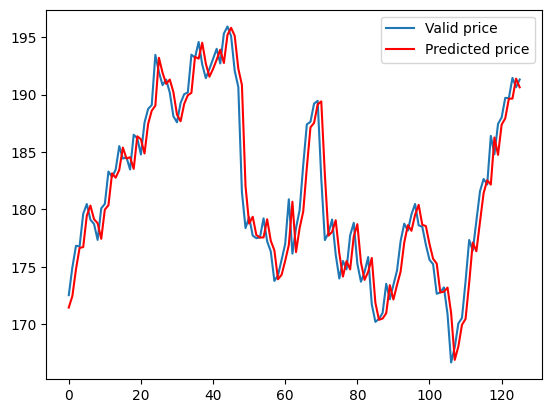

In [4]:
# ARIMA Walk Forward Validation for checking the validity of the model
test_size = 0.1
train_size = np.int(len(train_set) *(1-test_size))
last_index = len(train_set)
predictions = list()
valids = list()

for i in tqdm(range(train_size, last_index)):
    train, valid = train_set[0:i], train_set[i:i+1]
    d = diff_data(train)
    model = ARIMA(train, order=(2,d,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output
    predictions.append(yhat)
    valids.append(valid)

# evaluate MAPE
ARIMA_MAPE = mean_absolute_percentage_error(valids, predictions)
print("ARIMA method MAPE = %0.3f "%ARIMA_MAPE)
# plot predictions against actual outcomes
plt.plot(valids, label="Valid price")
plt.plot(predictions, color='red', label ="Predicted price")
plt.legend()
plt.show()

,LinearRegression,DecisionTreeRegressor,KNeighborsRegressor,BaggingRegressor,RandomForestRegressor
0,0.006011,0.01046,0.011469,0.008638,0.008666


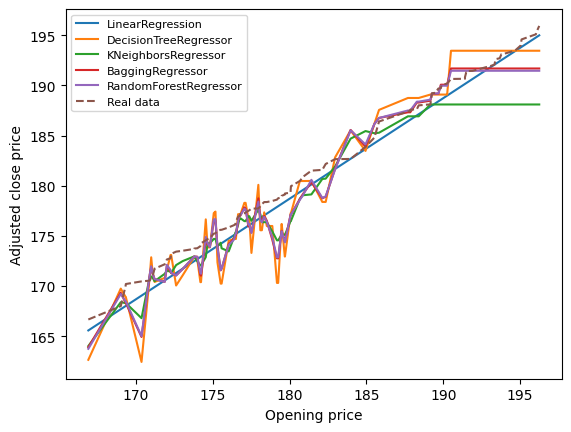

In [13]:
""" Using regression methods such as LinearRegression, DecisionTreeRegressor, KNeighborsRegressor, etc. to forecast the future price of a stock.
An effecient regression mehtod can predic the future price of a stock using the opening price of the same stock. Therefore , it can be presented as follow:
ŷ = f(opening price) where ŷ indicates the future value and f represents the regression model.
"""

# Split train and test dataset and scale the sets
def split_data_scaled (data , test_size= None):
    input = pd.DataFrame(data)
    input = input.reset_index(drop=True)
    Xtrain_set = np.array(input.Open).reshape(-1, 1)
    Ytrain_set = np.array(input['Adj Close']).reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_dataset = scaler.fit_transform(Ytrain_set)
    X_train, X_test, y_train, y_test = train_test_split(Xtrain_set, scaled_dataset, test_size=test_size, shuffle=False)
    return X_train, X_test, y_train, y_test, scaler

# Introduce regression models to be fitted
def get_models():
    models = list()
    models.append(LinearRegression())
    models.append(DecisionTreeRegressor(max_depth=100))
    models.append(KNeighborsRegressor())
    models.append(BaggingRegressor(n_estimators=100))
    models.append(RandomForestRegressor(n_estimators=1000))
    return models

# Fit the models
def fit_base_models(X, y, models):
	for model in models:
	    model.fit(X, y)

# Evalute the the fitted models
def evaluate_models(inputs, outputs, models, scaler):
    MAPE_list = pd.DataFrame()
    valids_ = np.stack((X_valid, y_valid), axis=1)
    valids_ = np.sort(valids_, axis = 0)
    inputs = valids_[:,0]
    outputs = valids_[:,1]
    for model in models:
        yhat = model.predict(inputs)
        yhat = yhat.reshape(-1,1)
        outputs = outputs.reshape(-1,1)
        outputs_ = scaler.inverse_transform(outputs)
        yhat_ = scaler.inverse_transform(yhat)

        accuracy = mean_absolute_percentage_error(outputs_, yhat_)
        MAPE_list[model.__class__.__name__] = [accuracy]
        plt.plot(inputs , yhat_, label="%s" %model.__class__.__name__)
    plt.plot(inputs , outputs_, "--", label="Real data")
    plt.xlabel('Opening price')
    plt.ylabel('Adjusted close price')
    plt.legend(fontsize="8", loc ="upper left")
    return MAPE_list

models = get_models()
X_train, X_valid, y_train, y_valid, scaler = split_data_scaled (data , test_size= 0.08)
fit_base_models(X_train, y_train, models)
reg_MAPE_list = evaluate_models(X_valid, y_valid, models, scaler)
reg_MAPE_list

In [6]:
# Using Neural Network model to predict the future value of a stock price using the opening price of the stock

# Neural Network structure
def Neural_network_model (inputs, outputs):
    n_inputs = np.size(inputs, 1)
    model = Sequential()
    model.add(Dense(128, kernel_initializer='normal', activation='linear'))
    model.add(Dense(128, kernel_initializer='normal', activation='linear'))
    model.add(Dense(128, kernel_initializer='normal', activation='linear'))
    model.add(Dense(1, kernel_initializer='normal', activation = "linear"))
    model.compile( loss='mean_absolute_error', optimizer='adam', metrics=None)
    return model

model = Neural_network_model (X_train, y_train)
history_ = model.fit(X_train, y_train, epochs = 200, validation_data=(X_valid,y_valid), batch_size = 30, verbose =0)


4/4 [==============================] - 0s 4ms/step
NN MAPE value is 0.009


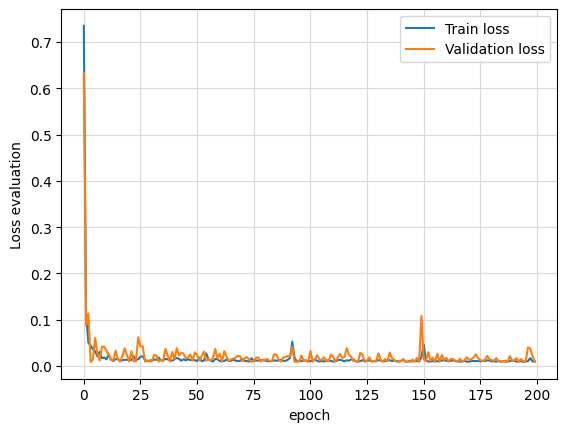

In [7]:
# Evaluate Nueral network model
y_model = model.predict (X_valid)
y_model = scaler.inverse_transform(y_model)
y_test= scaler.inverse_transform(y_valid)
NN_MAPE = mean_absolute_percentage_error(y_model, y_test)
print('NN MAPE value is %0.3f' %NN_MAPE)

plt.plot(history_.history['loss'], label = "Train loss")
plt.plot(history_.history['val_loss'], label = "Validation loss")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Loss evaluation')
plt.xlabel('epoch')
plt.grid(axis='both', color='0.85')
plt.show()

Brownian motion MAPE 0.068


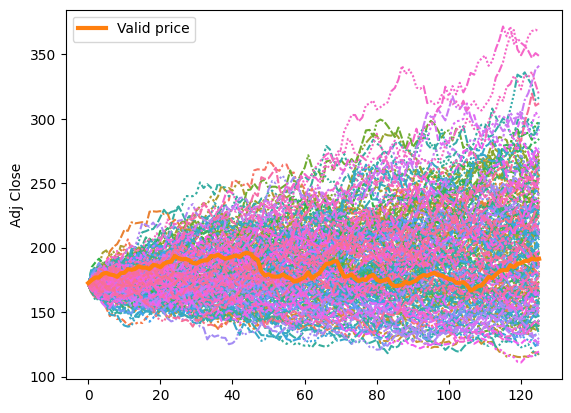

In [16]:
""" Using a physics-based simualtion model so-caled Geometric Brownian Motion model to simulate the future value of a stock price.
Geometric Brownian Motion (GBM) model forms the basis for the Black–Scholes equation where the log returns of stock prices is modelled: the main interest is in the option pricing of derivatives.
GBM has two components; a drift of the stock which represents the return that the stock will earn over a short period of time.
And, a stochastic process including the stocks volatility and an element of random volatility """

# Evalute daily return
def log_return(data):
    return data.pct_change().dropna()

# Evaluate the drift in price
def evaluate_drift(data):
    log_data = log_return(data)
    mean = log_data.mean()
    var = log_data.var()
    drift = mean - var/2
    return drift

# Define the simulation
def Brownian_motion (data,valid , days, NMC):
    """
    Inputs:
    data = Old prices
    valid = Old prices for model validation
    days = Number of days to be predicted
    NMC = Number of simulation

    Output:
    Simulation plot
    MAPE = mean absolute percentage error of the simulation
    """
    last_price = data.iloc[-1]
    ft = evaluate_drift(data)
    stv = log_return(data).std()
    real_price = data[-10:-1]
    valid = valid.reset_index()
    # This distribution is called cauchy distribution
    dr = np.exp(ft + stv * norm.ppf(np.random.rand(days, NMC)))

    price_list = np.zeros((days, NMC))
    price_list[0] = last_price
    for iter in range(1 , days):
        price_list[iter] = price_list[iter-1]*dr[iter]
    price_list = pd.DataFrame(price_list)
    MAPE = mean_absolute_percentage_error(price_list.mean(axis=1), valid['Adj Close'])
    print("Brownian motion MAPE %0.3f"%MAPE)
    fig = sns.lineplot(price_list, legend = False )
    fig = sns.lineplot(valid['Adj Close'], label= "Valid price", linewidth = 3)
    return MAPE

train, valid = split_data (train_set , test_size= 0.1, split_date=None)
days = len(valid)
BM_MAPE = Brownian_motion(train['Adj Close'],valid ,  days, 200)

Text(0.5, 0, 'MAPE')

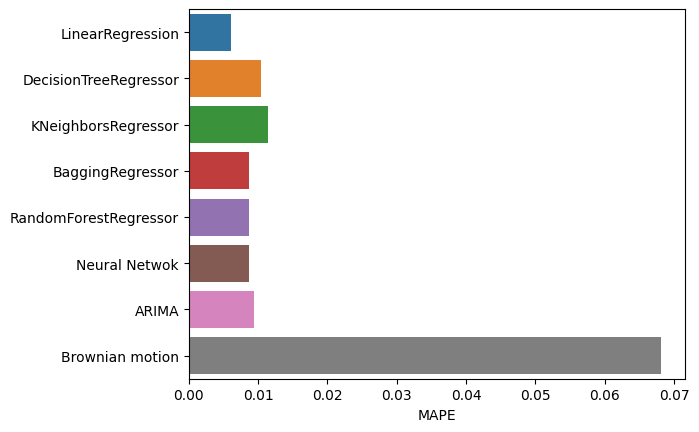

In [17]:
# Compare the methods MAPE
comparison = reg_MAPE_list
comparison['Neural Netwok'] = [NN_MAPE]
comparison['ARIMA'] = [ARIMA_MAPE]
comparison['Brownian motion'] = [BM_MAPE]
comparison
sns.barplot(comparison, orient='h')
plt.xlabel("MAPE")

""" Conclusion: Each model has its own complexity in application and defention, however, it has to be noticed that some may only be used
for either short or long term prediction and the choose of right model depends on user ."""
